In [1]:
import dpsimpy
from math import pi

In [2]:
# ----------------- Configurations ----------------- #
# Network
Vnom = 6.9e3;
nomFreq = 50;
nomOmega= nomFreq* 2* pi;

# Generator 1 (Bus 1)
nomPower_G1 = 100e6
nomPhPhVoltRMS_G1 = 6.9e3
nomFreq_G1 = 50
initActivePower_G1 = 0.3386e6
initReactivePower_G1= 0.3222e6
setPointVoltage_G1=nomPhPhVoltRMS_G1
powerflow_bus_type_G1 = dpsimpy.PowerflowBusType.VD

# Generator 2 (Bus 2)
nomPower_G2 = 100e6
nomPhPhVoltRMS_G2 = 6.9e3
nomFreq_G2 = 50
initActivePower_G2 = 0.2222e6
initReactivePower_G2=(-1)*0.0285e6
setPointVoltage_G2=nomPhPhVoltRMS_G2
powerflow_bus_type_G2 = dpsimpy.PowerflowBusType.PV

# Transformer
t1_ratio = 1;
t2_ratio = 1;

# Load (Bus 3)
activePower_L= 0.5556e6;
reactivePower_L= 0.2778e6;

# Transmission Lines
lineResistance = 0.025;
lineInductance = 0.075/ (2* pi* 50);
lineCapacitance = 0;
# ----------------- End of Configurations ----------------- #

In [3]:
# Nodes
gnd = dpsimpy.sp.SimNode.gnd
n1_PF = dpsimpy.sp.SimNode("n1", dpsimpy.PhaseType.Single)
n2_PF = dpsimpy.sp.SimNode("n2", dpsimpy.PhaseType.Single)
n3_PF = dpsimpy.sp.SimNode("n3", dpsimpy.PhaseType.Single)


# Generators
gen1_PF = dpsimpy.sp.ph1.SynchronGenerator("Generator_1")
gen1_PF.set_parameters(nomPower_G1, nomPhPhVoltRMS_G1, initActivePower_G1, setPointVoltage_G1 * t1_ratio, powerflow_bus_type_G1, initReactivePower_G1)
gen1_PF.set_base_voltage(Vnom)

gen2_PF = dpsimpy.sp.ph1.SynchronGenerator("Generator_2")
gen2_PF.set_parameters(nomPower_G1, nomPhPhVoltRMS_G2, initActivePower_G2, setPointVoltage_G2 * t2_ratio, powerflow_bus_type_G2, initReactivePower_G2)
gen2_PF.set_base_voltage(Vnom)

# Load
load_PF = dpsimpy.sp.ph1.Shunt("Load")
load_PF.set_parameters(activePower_L / (Vnom ** 2), -reactivePower_L / (Vnom ** 2))
load_PF.set_base_voltage(Vnom)

# Lines
line_PF_1 = dpsimpy.sp.ph1.PiLine("PiLine_12")
line_PF_1.set_parameters(lineResistance, lineInductance, lineCapacitance)
line_PF_1.set_base_voltage(Vnom)

line_PF_2 = dpsimpy.sp.ph1.PiLine("PiLine_13")
line_PF_2.set_parameters(lineResistance, lineInductance, lineCapacitance)
line_PF_2.set_base_voltage(Vnom)

line_PF_3 = dpsimpy.sp.ph1.PiLine("PiLine_23")
line_PF_3.set_parameters(lineResistance, 2 * lineInductance, 2 * lineCapacitance)
line_PF_3.set_base_voltage(Vnom)

# PMU Devices
pmu_1 = dpsimpy.signal.PMUSignalDevice("pmu_1")
pmu_1.set_parameters(0.089)
pmu_1.attr("input").set_reference(n1_PF.attr("v"))
           
pmu_2 = dpsimpy.signal.PMUSignalDevice("pmu_2")
pmu_2.set_parameters(0.073)
pmu_2.attr("input").set_reference(n2_PF.attr("v"))

pmu_3 = dpsimpy.signal.PMUSignalDevice("pmu_3")
pmu_3.set_parameters(0.097)
pmu_3.attr("input").set_reference(n3_PF.attr("v"))

[09:28:49.507515 PiLine_12 warning] Zero value for Capacitance, setting default value of C=1e-12 [F]
[09:28:49.507636 PiLine_12 warning] Zero value for Conductance, setting default value of G=1e-06 [S]
[09:28:49.508612 PiLine_13 warning] Zero value for Capacitance, setting default value of C=1e-12 [F]
[09:28:49.508636 PiLine_13 warning] Zero value for Conductance, setting default value of G=1e-06 [S]
[09:28:49.509613 PiLine_23 warning] Zero value for Capacitance, setting default value of C=1e-12 [F]
[09:28:49.509632 PiLine_23 warning] Zero value for Conductance, setting default value of G=1e-06 [S]


In [4]:
# Topology
gen1_PF.connect([n1_PF])
gen2_PF.connect([n2_PF])
load_PF.connect([n3_PF])
line_PF_1.connect([n1_PF, n2_PF])
line_PF_2.connect([n1_PF, n3_PF])
line_PF_3.connect([n2_PF, n3_PF])

systemPF = dpsimpy.SystemTopology(50, [n1_PF, n2_PF, n3_PF], [gen1_PF, gen2_PF, line_PF_1, line_PF_2, line_PF_3, load_PF])
systemPF.add([pmu_1, pmu_2, pmu_3])

In [5]:
# Logging
log = dpsimpy.Logger("Three_bus_sim")
log.log_attribute("v_bus1", n1_PF.attr("v"))
log.log_attribute("v_bus2", n2_PF.attr("v"))
log.log_attribute("v_bus3", n3_PF.attr("v"))
log.log_attribute("pmu_input_1", pmu_1.attr("input"))
log.log_attribute("pmu_output_1", pmu_1.attr("output"))
log.log_attribute("pmu_input_2", pmu_2.attr("input"))
log.log_attribute("pmu_output_2", pmu_2.attr("output"))
log.log_attribute("pmu_input_3", pmu_3.attr("input"))
log.log_attribute("pmu_output_3", pmu_3.attr("output"))

In [6]:
# Simulation
sim = dpsimpy.Simulation("Three_bus_sim", loglevel=dpsimpy.LogLevel.debug)
sim.set_system(systemPF)
sim.set_time_step(0.001)
sim.set_final_time(0.1)
sim.set_domain(dpsimpy.Domain.SP)
sim.set_solver(dpsimpy.Solver.NRP)
sim.set_solver_component_behaviour(dpsimpy.SolverBehaviour.Initialization)
sim.do_init_from_nodes_and_terminals(False)
sim.add_logger(log)
sim.run()

[09:29:40.952371 Three_bus_sim info] Initialize simulation: Three_bus_sim
[09:29:40.963909 Three_bus_sim info] Scheduling tasks.
[09:29:40.965246 Three_bus_sim info] Scheduling done.
[09:29:40.965256 Three_bus_sim info] Opening interfaces.
[09:29:40.965260 Three_bus_sim info] Start synchronization with remotes on interfaces
[09:29:40.965264 Three_bus_sim info] Synchronized simulation start with remotes
[09:29:40.965272 Three_bus_sim info] Start simulation: Three_bus_sim
[09:29:40.965338 Three_bus_sim info] Time step: 1.000000e-03
[09:29:40.965356 Three_bus_sim info] Final time: 1.000000e-01
[09:29:41.193936 Three_bus_sim info] Simulation calculation time: 0.228560
[09:29:41.194115 Three_bus_sim info] Simulation finished.


column number: 9
results length: 100
real column names: []
complex column names: ['pmu_input_1', 'pmu_input_2', 'pmu_input_3', 'pmu_output_1', 'pmu_output_2', 'pmu_output_3', 'v_bus1', 'v_bus2', 'v_bus3']


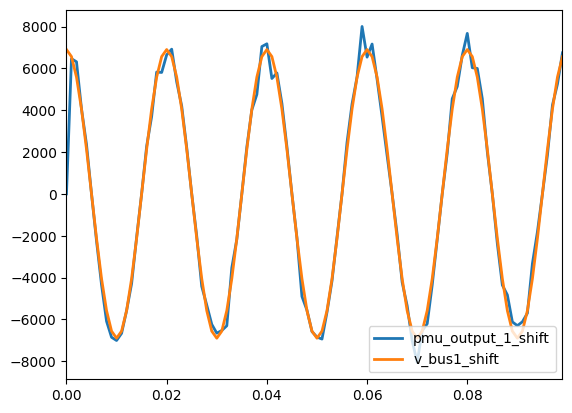

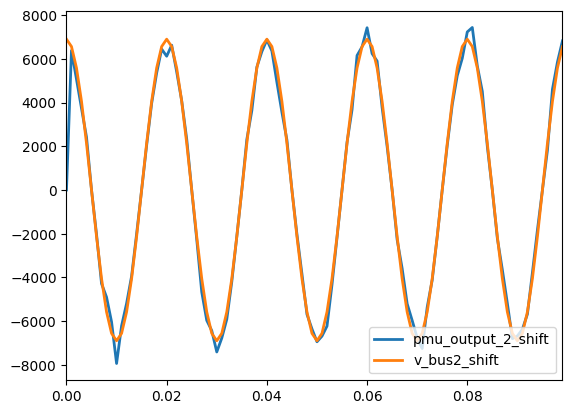

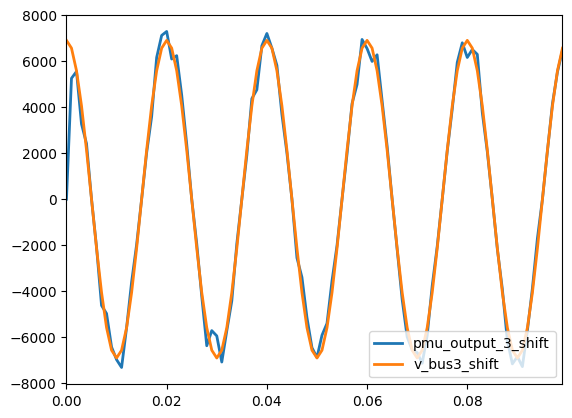

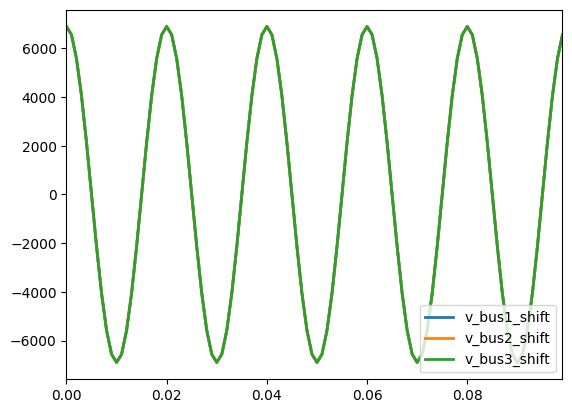

In [7]:
# Visualization
import villas.dataprocessing.plottools as pt
import villas.dataprocessing.readtools as rt

results     = rt.read_timeseries_dpsim('logs/Three_bus_sim.csv')
results_shift = [ results[series].frequency_shift(freq=50) for series in results ]
pt.plot_timeseries('PMU1_output vs Bus1', results_shift[3])
pt.plot_timeseries('PMU1_output vs Bus1', results_shift[6])
pt.plot_timeseries('PMU2_output vs Bus2', results_shift[4])
pt.plot_timeseries('PMU2_output vs Bus2', results_shift[7])
pt.plot_timeseries('PMU3_output vs Bus3', results_shift[5])
pt.plot_timeseries('PMU3_output vs Bus3', results_shift[8])
pt.plot_timeseries('test', results_shift[6])
pt.plot_timeseries('test', results_shift[7])
pt.plot_timeseries('test', results_shift[8])